In [3]:
import os
import json
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import models
from torchvision.models import vit_b_16
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
simple_load = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
])

In [4]:
data_8known_base_path = 'data/processed8'
data_2known_base_path = 'data/processed2'
# data_8known_base_path = 'data/subset'
# data_2known_base_path = 'data/subset'

In [5]:
train_dataset_8known = ImageFolder(f'{data_8known_base_path}/train', transform=simple_load)
test_dataset_8known = ImageFolder(f'{data_8known_base_path}/test', transform=simple_load)
val_dataset_8known = ImageFolder(f'{data_8known_base_path}/valid', transform=simple_load)

train_dataset_2known = ImageFolder(f'{data_2known_base_path}/train', transform=simple_load)
test_dataset_2known = ImageFolder(f'{data_2known_base_path}/test', transform=simple_load)
val_dataset_2known = ImageFolder(f'{data_2known_base_path}/valid', transform=simple_load)

In [6]:
def get_image(path: str):
    image = torchvision.io.read_image(path)
    return v2.ToPILImage()(image)


def get_image_resized(path: str):
    image = get_image(path)
    # Resize required for ViT to work. It is done for all models for a fair comparison
    resize = v2.Resize((224, 224))
    bigger_image = resize(image)

    return v2.ToPILImage()(bigger_image)

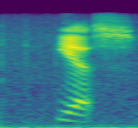

In [7]:
path = f'./{data_8known_base_path}/train/yes/004ae714_nohash_0.png'
get_image(path)

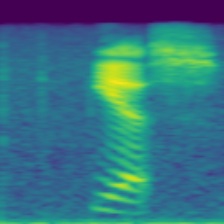

In [8]:
get_image_resized(path)

## Models

CNN Model Resnet-18 not pretrained (random weights)

In [9]:
def get_resnet(n_classes: int):
    model_resnet = models.resnet18(pretrained=False)

    output_features = model_resnet.fc.in_features 
    ## We have 512 output features, we have to add to model a fully connected layer for our 
    ## classification problem with only specified target classes
    model_resnet.fc = nn.Linear(output_features, n_classes)
    model_resnet = model_resnet.to(device)
    return model_resnet

Custom CRNN

In [10]:
class CustomCRNN(nn.Module):

    def __init__(self, n_classes: int):
        super(CustomCRNN, self).__init__()

        conv_channels = (32, 64, 128)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_channels[0], kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[0], kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv_channels[1], out_channels=conv_channels[1], kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=conv_channels[2], out_channels=conv_channels[2], kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.rnn = nn.LSTM(input_size=conv_channels[-1] * 24 * 24, hidden_size=256)
        self.fc = nn.Sequential(
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1),
        )
        self.to(device)

    def forward(self, obs) -> torch.Tensor:
        out_conv = self.conv(obs)
        out_conv_flat = self.flatten(out_conv)
        try:
            out_rnn = self.rnn(out_conv_flat)[0]
        except RuntimeError:
            raise RuntimeError(f'Output of convolutional block is shaped {out_conv.shape} and it does not match LSTM input')
        out_proba = self.fc(out_rnn)
        return out_proba

Transformer VIT-base-16

In [11]:
def get_vit_base():
    vit_base = vit_b_16()
    vit_base.to(device)
    return vit_base

## Train function

In [12]:
def train(network: nn.Module, train_dataset: ImageFolder, valid_dataset: ImageFolder, batch_size: int,
          loss_fn, optimizer: torch.optim.Optimizer, max_epochs: int, cooldown_min=0,
          save_name: str | None = None, verbosity_period=1) -> dict[str, list[float]]:
    """
    Based on: https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

    Returns:
        training statstics
    """
    train_loss_per_epoch: list[float] = []
    train_accuracy_per_epoch: list[float] = []
    valid_loss_per_epoch: list[float] = []
    valid_accuracy_per_epoch: list[float] = []

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(max_epochs):
        epoch = epoch + 1

        # setup for training
        network.train()
        train_epoch_loss_sum = 0.0
        train_epoch_true_count = 0

        # training loop
        for images, true_labels in train_data_loader:

            # move to the device (especially necessary when using cuda)
            images = images.to(device)
            true_labels = true_labels.to(device)

            # feed forward
            optimizer.zero_grad()
            pred_proba = network(images)

            loss = loss_fn(pred_proba, true_labels)
            # backpropagation and update weights
            loss.backward()
            optimizer.step()

            # update current epoch's stats
            train_epoch_loss_sum += loss.item() * images.size(0)
            # calculate accuracy but only if no advanced augmentations are used
            # this is because with advanced augmentations true_labels becomes
            # probabilites of each class
            pred_labels = torch.argmax(pred_proba, dim=1)
            train_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_train_loss = float(train_epoch_loss_sum / len(train_dataset))
        curr_train_accuracy = float(train_epoch_true_count.double() / len(train_dataset))
        train_loss_per_epoch.append(curr_train_loss)
        train_accuracy_per_epoch.append(curr_train_accuracy)

        # setup for validation
        network.eval()
        valid_epoch_loss_sum = 0.0
        valid_epoch_true_count = 0

        with torch.no_grad():
            # same as before but on validation data
            for images, true_labels in valid_data_loader:
                # move to device
                images = images.to(device)
                true_labels = true_labels.to(device)

                # make a prediction
                pred_proba = network(images)
                pred_labels = torch.argmax(pred_proba, dim=1)
                loss = loss_fn(pred_proba, true_labels)

                # update stats
                valid_epoch_loss_sum += loss.item() * images.size(0)
                valid_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_valid_loss = float(valid_epoch_loss_sum / len(valid_dataset))
        curr_valid_acccuracy = float(valid_epoch_true_count.double() / len(valid_dataset))
        valid_loss_per_epoch.append(curr_valid_loss)
        valid_accuracy_per_epoch.append(curr_valid_acccuracy)

        # Verbosity
        if verbosity_period > 0 and epoch % verbosity_period == 0:
            train_acc_text = ''
            train_acc_text = f'Train accuracy: {curr_train_accuracy:.4f} | '
            print(f'Epoch {epoch} completed! | '
                  f'Train loss: {curr_train_loss:.4f} | '
                  f'{train_acc_text}'
                  f'Validation loss: {curr_valid_loss:.4f} | '
                  f'Validation accuracy: {curr_valid_acccuracy:.4f}')
            
        # Cooldown
        if cooldown_min > 0:
            time.sleep(cooldown_min * 60)

    stats = {
        'train_loss': train_loss_per_epoch,
        'train_accuracy': train_accuracy_per_epoch,
        'valid_loss': valid_loss_per_epoch,
        'valid_accuracy': valid_accuracy_per_epoch,
    }

    # save network weights and stats at the end
    if save_name is not None:
        # prepare save dir
        datetime_id = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
        save_dir = os.path.join('.', 'saved', f'{save_name}_{datetime_id}')
        os.makedirs(save_dir, exist_ok=True)
        # save network weights
        model_path = os.path.join(save_dir, f'{save_name}.pth')
        torch.save(network.state_dict(), model_path)
        # save training stats
        stats_path = os.path.join(save_dir, f'{save_name}.json')
        with open(stats_path, 'w') as file:
            json.dump(stats, file)
    
    return stats

In [13]:
def load_weights(network_fresh: nn.Module, path: str) -> None:
    """Loads saved weights to the given network"""
    network_fresh.load_state_dict(torch.load(path, map_location=torch.device(device)))
    network_fresh.eval()

In [14]:
def load_stats(path: str) -> dict[str, list[float]]:
    with open(path) as file:
        stats = json.load(file)
    return stats

# Train models

### Train Resnet-18 not pretrained

In [15]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_resnet = get_resnet(9)

# 28 min (15 epochs)
stats_resnet = train(
    model_resnet, train_dataset_8known, val_dataset_8known, 
    batch_size=64, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_resnet.parameters(), lr=0.001), 
    max_epochs=15,
    save_name='architectures_resnet',
)

Epoch 1 completed! | Train loss: 0.5452 | Train accuracy: 0.8216 | Validation loss: 0.4236 | Validation accuracy: 0.8683
Epoch 2 completed! | Train loss: 0.2102 | Train accuracy: 0.9328 | Validation loss: 0.6085 | Validation accuracy: 0.8134
Epoch 3 completed! | Train loss: 0.1523 | Train accuracy: 0.9515 | Validation loss: 0.1450 | Validation accuracy: 0.9486
Epoch 4 completed! | Train loss: 0.1188 | Train accuracy: 0.9620 | Validation loss: 0.2116 | Validation accuracy: 0.9300
Epoch 5 completed! | Train loss: 0.1025 | Train accuracy: 0.9661 | Validation loss: 0.1704 | Validation accuracy: 0.9443
Epoch 6 completed! | Train loss: 0.0821 | Train accuracy: 0.9734 | Validation loss: 0.2103 | Validation accuracy: 0.9339
Epoch 7 completed! | Train loss: 0.0703 | Train accuracy: 0.9758 | Validation loss: 0.4506 | Validation accuracy: 0.8790
Epoch 8 completed! | Train loss: 0.0653 | Train accuracy: 0.9783 | Validation loss: 0.1908 | Validation accuracy: 0.9469
Epoch 9 completed! | Train loss:

### Custom CRNN

In [ ]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_crnn = CustomCRNN(9)

# 45 min (15 epochs)
stats_crnn = train(
    model_crnn, train_dataset_8known, val_dataset_8known, 
    batch_size=32, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_crnn.parameters(), lr=0.0001), 
    max_epochs=15,
    save_name='best_crnn_long',
)

Epoch 1 completed! | Train loss: 2.0389 | Train accuracy: 0.4227 | Validation loss: 1.9009 | Validation accuracy: 0.5909
Epoch 2 completed! | Train loss: 1.8194 | Train accuracy: 0.6446 | Validation loss: 1.7256 | Validation accuracy: 0.7067
Epoch 3 completed! | Train loss: 1.6858 | Train accuracy: 0.7379 | Validation loss: 1.6123 | Validation accuracy: 0.8268
Epoch 4 completed! | Train loss: 1.5740 | Train accuracy: 0.8542 | Validation loss: 1.5518 | Validation accuracy: 0.8613
Epoch 5 completed! | Train loss: 1.5201 | Train accuracy: 0.8946 | Validation loss: 1.5230 | Validation accuracy: 0.8860
Epoch 6 completed! | Train loss: 1.4888 | Train accuracy: 0.9163 | Validation loss: 1.5095 | Validation accuracy: 0.8929
Epoch 7 completed! | Train loss: 1.4650 | Train accuracy: 0.9356 | Validation loss: 1.4995 | Validation accuracy: 0.8972
Epoch 8 completed! | Train loss: 1.4472 | Train accuracy: 0.9488 | Validation loss: 1.4870 | Validation accuracy: 0.9041
Epoch 9 completed! | Train loss:

In [15]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_crnn = CustomCRNN(9)

# 25 min (10 epochs)
stats_crnn = train(
    model_crnn, train_dataset_8known, val_dataset_8known, 
    batch_size=32, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_crnn.parameters(), lr=0.0001), 
    max_epochs=10,
    save_name='architectures_crnn',
)

Epoch 1 completed! | Train loss: 2.0398 | Train accuracy: 0.4180 | Validation loss: 1.9084 | Validation accuracy: 0.6125
Epoch 2 completed! | Train loss: 1.8175 | Train accuracy: 0.6490 | Validation loss: 1.7215 | Validation accuracy: 0.7171
Epoch 3 completed! | Train loss: 1.6665 | Train accuracy: 0.7689 | Validation loss: 1.5939 | Validation accuracy: 0.8341
Epoch 4 completed! | Train loss: 1.5622 | Train accuracy: 0.8604 | Validation loss: 1.5454 | Validation accuracy: 0.8691
Epoch 5 completed! | Train loss: 1.5171 | Train accuracy: 0.8956 | Validation loss: 1.5260 | Validation accuracy: 0.8834
Epoch 6 completed! | Train loss: 1.4872 | Train accuracy: 0.9191 | Validation loss: 1.5068 | Validation accuracy: 0.8916
Epoch 7 completed! | Train loss: 1.4648 | Train accuracy: 0.9353 | Validation loss: 1.4966 | Validation accuracy: 0.8998
Epoch 8 completed! | Train loss: 1.4471 | Train accuracy: 0.9477 | Validation loss: 1.4883 | Validation accuracy: 0.9063
Epoch 9 completed! | Train loss:

### Train vit base

Due to very long training times, we have decided to train the ViTs only on 2 classes.

In [23]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

vit_base = get_vit_base()

# 94 min (20 epochs)
stats_vit_base = train(
    vit_base, train_dataset_2known, val_dataset_2known, 
    batch_size=16, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(vit_base.parameters(), lr=0.001), 
    max_epochs=20,
    save_name='architectures_vit_base',
)

Epoch 1 completed! | Train loss: 1.1798 | Train accuracy: 0.3378 | Validation loss: 1.1129 | Validation accuracy: 0.3300
Epoch 2 completed! | Train loss: 1.1132 | Train accuracy: 0.3301 | Validation loss: 1.1022 | Validation accuracy: 0.3287
Epoch 3 completed! | Train loss: 1.1085 | Train accuracy: 0.3351 | Validation loss: 1.1034 | Validation accuracy: 0.3413
Epoch 4 completed! | Train loss: 1.1016 | Train accuracy: 0.3450 | Validation loss: 1.1043 | Validation accuracy: 0.3350
Epoch 5 completed! | Train loss: 1.0662 | Train accuracy: 0.4212 | Validation loss: 1.0163 | Validation accuracy: 0.4627
Epoch 6 completed! | Train loss: 1.0456 | Train accuracy: 0.4363 | Validation loss: 1.1017 | Validation accuracy: 0.4412
Epoch 7 completed! | Train loss: 1.0651 | Train accuracy: 0.4336 | Validation loss: 1.0858 | Validation accuracy: 0.3755
Epoch 8 completed! | Train loss: 1.0745 | Train accuracy: 0.3998 | Validation loss: 1.0342 | Validation accuracy: 0.4665
Epoch 9 completed! | Train loss:

# Hyperparameters

In [17]:
from typing import Any
from bayes_opt import BayesianOptimization

In [18]:
def save_bayes_result(path: str, best_params: dict[str, Any], best_accuracy: float):
    data = {
        'best_params': best_params,
        'best_accuracy': best_accuracy,
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as file:
        json.dump(data, file)


def load_bayes_result(path: str) -> tuple[dict[str, Any], float]:
    with open(path, 'r') as file:
        data = json.load(file)
    return data['best_params'], data['best_accuracy']

### ResNet-18 (8 known classes)

In [17]:
def objective_function_resnet_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_resnet(9)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_8known, val_dataset_8known, batch_size, criterion, optimizer, max_epochs=10, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [18]:
pbounds = {
    'batch_size_exp': (3, 6.999),  # will be rounded down so from 3 to 6, making batch size from 8 to 64
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99),
}
optimizer = BayesianOptimization(
    f=objective_function_resnet_adam,
    pbounds=pbounds,
    random_state=42
)
# 306 min
optimizer.maximize(
    init_points=4,
    n_iter=10,
)
best_hyperparams_resnet_adam = optimizer.max['params']
accuracy_resnet_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/resnet8_adam.json', best_hyperparams_resnet_adam, accuracy_resnet_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 0.9205    | 4.498     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 0.1382    | 3.624     | 0.0575    | 0.8575    | 0.006015  | 0.00711   |
| 3         | 0.9274    | 3.082     | 0.9602    | 0.8241    | 0.002131  | 0.0019    |
| 4         | 0.5067    | 3.733     | 0.3012    | 0.5195    | 0.004325  | 0.002983  |
| 5         | 0.7011    | 3.021     | 0.975     | 0.8691    | 0.008952  | 0.006627  |
| 6         | 0.9546    | 3.189     | 0.9342    | 0.7452    | 1e-05     | 0.0001    |
| 7         | 0.9512    | 3.038     | 0.99      | 0.5801    | 1e-05     | 0.0001    |
| 8         | 0.7378    | 3.041     | 0.7314    | 0.6295    | 0.004944  | 0.002886  |
| 9         | 0.3387    | 6.229     | 0.174     | 0.3136    | 0.002696  | 0.007286  |
| 10        | 0.8786    | 4.762     | 0.99      | 0.75

Bayes Search did not improve this model

### ResNet-18 (2 known classes)

In [19]:
def objective_function_resnet_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_resnet(3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_2known, val_dataset_2known, batch_size, criterion, optimizer, max_epochs=10, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [20]:
pbounds = {
    'batch_size_exp': (3, 6.999),  # will be rounded down so from 3 to 6, making batch size from 8 to 64
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99),
}
optimizer = BayesianOptimization(
    f=objective_function_resnet_adam,
    pbounds=pbounds,
    random_state=42
)
# 97 min
optimizer.maximize(
    init_points=4,
    n_iter=10,
)
best_hyperparams_resnet_adam = optimizer.max['params']
accuracy_resnet_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/resnet2_adam.json', best_hyperparams_resnet_adam, accuracy_resnet_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 0.8913    | 4.498     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 0.3413    | 3.624     | 0.0575    | 0.8575    | 0.006015  | 0.00711   |
| 3         | 0.9456    | 3.082     | 0.9602    | 0.8241    | 0.002131  | 0.0019    |
| 4         | 0.9381    | 3.733     | 0.3012    | 0.5195    | 0.004325  | 0.002983  |
| 5         | 0.3755    | 4.548     | 0.6842    | 0.2555    | 0.008322  | 0.006137  |
| 6         | 0.33      | 6.625     | 0.1043    | 0.1458    | 0.009254  | 0.00773   |
| 7         | 0.4437    | 5.335     | 0.04731   | 0.03545   | 0.001054  | 0.002409  |
| 8         | 0.9077    | 4.874     | 0.9831    | 0.9126    | 0.004324  | 0.003224  |
| 9         | 0.3767    | 6.229     | 0.174     | 0.3136    | 0.002696  | 0.007286  |
| 10        | 0.9684    | 4.618     | 0.99      | 0.95

### CRNN

In [19]:
def objective_function_customcrnn_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = CustomCRNN(9)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_8known, val_dataset_8known, batch_size, criterion, optimizer, max_epochs=10, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [20]:
pbounds = {
    'batch_size_exp': (3, 6.999),  # will be rounded down so from 3 to 6, making batch size from 8 to 64
    'learning_rate': (1e-5, 1e-3),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99),
}
optimizer = BayesianOptimization(
    f=objective_function_customcrnn_adam,
    pbounds=pbounds,
    random_state=42
)
# 560 min
optimizer.maximize(
    init_points=4,
    n_iter=10
)
best_hyperparams_customcrnn = optimizer.max['params']
accuracy_customcrnn = optimizer.max['target']
save_bayes_result('./saved/bayes/customcrnn_adam.json', best_hyperparams_customcrnn, accuracy_customcrnn)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 0.7421    | 4.498     | 0.9412    | 0.7247    | 0.005991  | 0.0001645 |
| 2         | 0.1132    | 3.624     | 0.0575    | 0.8575    | 0.006015  | 0.000711  |
| 3         | 0.8099    | 3.082     | 0.9602    | 0.8241    | 0.002131  | 0.00019   |
| 4         | 0.111     | 3.733     | 0.3012    | 0.5195    | 0.004325  | 0.0002983 |
| 5         | 0.5037    | 3.021     | 0.975     | 0.8691    | 0.008952  | 0.0006627 |
| 6         | 0.8268    | 3.14      | 0.9463    | 0.7819    | 1e-05     | 1e-05     |
| 7         | 0.8199    | 3.229     | 0.9564    | 0.9164    | 1e-05     | 1e-05     |
| 8         | 0.111     | 3.192     | 0.7952    | 0.8745    | 0.00633   | 0.0009281 |
| 9         | 0.7451    | 6.229     | 0.174     | 0.3136    | 0.002696  | 0.0007286 |
| 10        | 0.1106    | 3.248     | 0.9722    | 0.82

Bayes search did not improve this model

### Transformer VIT-base-16

In [26]:
def objective_function_vit_base_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_vit_base()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_2known, val_dataset_2known, batch_size, criterion, optimizer, max_epochs=15, verbosity_period=0)
    # Cooldown for 5mins
    time.sleep(5 * 60)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [27]:
pbounds = {
    'batch_size_exp': (3, 5.999),  # will be rounded down so from 3 to 5, making batch size from 8 to 32
    'learning_rate': (1e-4, 0.1),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
    
}
optimizer = BayesianOptimization(
    f=objective_function_vit_base_adam,
    pbounds=pbounds,
    random_state=42
)
# 1272 min
optimizer.maximize(
    init_points=4,
    n_iter=10,
)
best_hyperparams_vit_base_adam = optimizer.max['params']
accuracy_vit_base_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/vit_base_adam.json', best_hyperparams_vit_base_adam, accuracy_vit_base_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 0.4235    | 4.123     | 0.9412    | 0.7247    | 0.005991  | 0.01569   |
| 2         | 0.3287    | 3.468     | 0.0575    | 0.8575    | 0.006015  | 0.07084   |
| 3         | 0.3287    | 3.062     | 0.9602    | 0.8241    | 0.002131  | 0.01826   |
| 4         | 0.3413    | 3.55      | 0.3012    | 0.5195    | 0.004325  | 0.02919   |
| 5         | 0.4412    | 4.553     | 0.99      | 0.6767    | 0.006846  | 0.0001    |
| 6         | 0.33      | 5.976     | 0.99      | 0.99      | 1e-05     | 0.1       |
| 7         | 0.3413    | 4.547     | 0.99      | 0.0       | 0.01      | 0.1       |
| 8         | 0.8483    | 4.525     | 0.7268    | 0.99      | 1e-05     | 0.0001    |
| 9         | 0.3186    | 5.422     | 0.174     | 0.3136    | 0.002696  | 0.07262   |
| 10        | 0.8205    | 4.547     | 0.5932    | 0.99

## Training the best models

### ViT base (2 known classes)

In [17]:
best_hyperparams_vit_base, accuracy_vit_base = load_bayes_result('./saved/bayes/vit_base_adam.json')

In [18]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_vit_base['batch_size_exp'])
best_learning_rate = best_hyperparams_vit_base['learning_rate']
best_l2_reg = best_hyperparams_vit_base['l2_reg']
best_beta1 = best_hyperparams_vit_base['beta1']
best_beta2 = best_hyperparams_vit_base['beta2']

model_best_vit_base_2 = get_vit_base()
optimizer = optim.Adam(
    model_best_vit_base_2.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
# 141 min (30 epochs)
stats_best_vit_base_2 = train(
    model_best_vit_base_2, train_dataset_2known, val_dataset_2known,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=30,
    save_name='best_vit_base_2',
)

Epoch 1 completed! | Train loss: 1.4912 | Train accuracy: 0.3698 | Validation loss: 1.0412 | Validation accuracy: 0.4589
Epoch 2 completed! | Train loss: 0.9994 | Train accuracy: 0.4341 | Validation loss: 0.9605 | Validation accuracy: 0.4564
Epoch 3 completed! | Train loss: 0.9838 | Train accuracy: 0.4403 | Validation loss: 0.9734 | Validation accuracy: 0.4223
Epoch 4 completed! | Train loss: 0.8758 | Train accuracy: 0.5804 | Validation loss: 0.7203 | Validation accuracy: 0.6953
Epoch 5 completed! | Train loss: 0.7330 | Train accuracy: 0.6672 | Validation loss: 0.6692 | Validation accuracy: 0.6953
Epoch 6 completed! | Train loss: 0.6871 | Train accuracy: 0.6913 | Validation loss: 0.6838 | Validation accuracy: 0.7143
Epoch 7 completed! | Train loss: 0.6562 | Train accuracy: 0.7119 | Validation loss: 0.6251 | Validation accuracy: 0.7130
Epoch 8 completed! | Train loss: 0.6136 | Train accuracy: 0.7321 | Validation loss: 0.5789 | Validation accuracy: 0.7446
Epoch 9 completed! | Train loss:

### ViT base (8 known classes)

We tried to train a model with the same hyperparameters but on a larger data

In [ ]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_vit_base['batch_size_exp'])
best_learning_rate = best_hyperparams_vit_base['learning_rate']
best_l2_reg = best_hyperparams_vit_base['l2_reg']
best_beta1 = best_hyperparams_vit_base['beta1']
best_beta2 = best_hyperparams_vit_base['beta2']

model_best_vit_base_8 = get_vit_base()
optimizer = optim.Adam(
    model_best_vit_base_8.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
# 211 min (15 epochs)
stats_best_vit_base_8 = train(
    model_best_vit_base_8, train_dataset_8known, val_dataset_8known,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=15,
    save_name='best_vit_base_8_long',
)

Epoch 1 completed! | Train loss: 2.2185 | Train accuracy: 0.1729 | Validation loss: 2.0621 | Validation accuracy: 0.2276
Epoch 2 completed! | Train loss: 1.7400 | Train accuracy: 0.3543 | Validation loss: 1.6334 | Validation accuracy: 0.4112
Epoch 3 completed! | Train loss: 1.4055 | Train accuracy: 0.4995 | Validation loss: 1.4231 | Validation accuracy: 0.4873
Epoch 4 completed! | Train loss: 1.1751 | Train accuracy: 0.5876 | Validation loss: 1.1238 | Validation accuracy: 0.6052
Epoch 5 completed! | Train loss: 1.0053 | Train accuracy: 0.6458 | Validation loss: 1.3500 | Validation accuracy: 0.5581
Epoch 6 completed! | Train loss: 0.8874 | Train accuracy: 0.6919 | Validation loss: 0.8775 | Validation accuracy: 0.6972
Epoch 7 completed! | Train loss: 0.7760 | Train accuracy: 0.7290 | Validation loss: 0.8704 | Validation accuracy: 0.6959
Epoch 8 completed! | Train loss: 0.6908 | Train accuracy: 0.7626 | Validation loss: 0.7563 | Validation accuracy: 0.7339
Epoch 9 completed! | Train loss:

There was a lot of overfitting which started to occur after 9th epoch. So now we train this for 9 epochs

In [46]:
torch.manual_seed(24)
torch.cuda.manual_seed(24)

best_batch_size_exp = int(best_hyperparams_vit_base['batch_size_exp'])
best_learning_rate = best_hyperparams_vit_base['learning_rate']
best_l2_reg = best_hyperparams_vit_base['l2_reg']
best_beta1 = best_hyperparams_vit_base['beta1']
best_beta2 = best_hyperparams_vit_base['beta2']

model_best_vit_base_8 = get_vit_base()
optimizer = optim.Adam(
    model_best_vit_base_8.parameters(), 
    lr=best_learning_rate, 
    weight_decay=best_l2_reg, 
    betas=(best_beta1, best_beta2)
)
# initially trained on 30 epochs but there was a lot of overfitting which started
# to occur after 9th epoch. So now we train this for 9 epochs
# 127 min (9 epochs)
stats_best_vit_base_8 = train(
    model_best_vit_base_8, train_dataset_8known, val_dataset_8known,
    batch_size=2**best_batch_size_exp,
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optimizer, 
    max_epochs=9,
    save_name='best_vit_base_8',
)

Epoch 1 completed! | Train loss: 2.2185 | Train accuracy: 0.1729 | Validation loss: 2.0621 | Validation accuracy: 0.2276
Epoch 2 completed! | Train loss: 1.7400 | Train accuracy: 0.3543 | Validation loss: 1.6334 | Validation accuracy: 0.4112
Epoch 3 completed! | Train loss: 1.4055 | Train accuracy: 0.4995 | Validation loss: 1.4231 | Validation accuracy: 0.4873
Epoch 4 completed! | Train loss: 1.1751 | Train accuracy: 0.5876 | Validation loss: 1.1238 | Validation accuracy: 0.6052
Epoch 5 completed! | Train loss: 1.0053 | Train accuracy: 0.6458 | Validation loss: 1.3500 | Validation accuracy: 0.5581
Epoch 6 completed! | Train loss: 0.8874 | Train accuracy: 0.6919 | Validation loss: 0.8775 | Validation accuracy: 0.6972
Epoch 7 completed! | Train loss: 0.7760 | Train accuracy: 0.7290 | Validation loss: 0.8704 | Validation accuracy: 0.6959
Epoch 8 completed! | Train loss: 0.6908 | Train accuracy: 0.7626 | Validation loss: 0.7563 | Validation accuracy: 0.7339
Epoch 9 completed! | Train loss:

## Training evaluation

In [24]:
architectures_crnn = load_stats('./saved/architectures_crnn/best_crnn_long.json')
architectures_resnet = load_stats('./saved/architectures_resnet/architectures_resnet.json')
best_vit_base_8 = load_stats('./saved/best_vit_base_8/best_vit_base_8_long.json')

### Custom CRNN

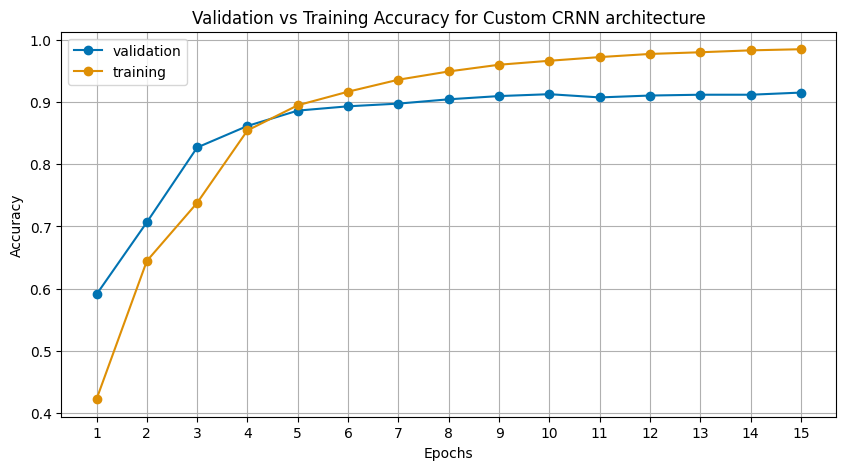

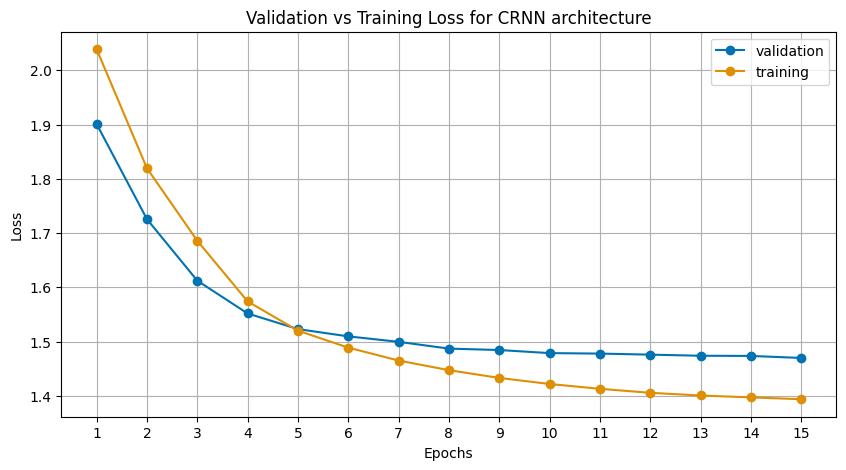

In [29]:
x_vals_crnn = list(range(1, len(architectures_crnn['valid_accuracy']) + 1))
# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_crnn, architectures_crnn['valid_accuracy'], label='validation', marker='o')
plt.plot(x_vals_crnn, architectures_crnn['train_accuracy'], label='training', marker='o')
plt.title('Validation vs Training Accuracy for Custom CRNN architecture')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals_crnn)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_crnn, architectures_crnn['valid_loss'], label='validation', marker='o')
plt.plot(x_vals_crnn, architectures_crnn['train_loss'], label='training', marker='o')
plt.title('Validation vs Training Loss for CRNN architecture')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_vals_crnn)
plt.grid(True)
plt.show()

### ResNet-18

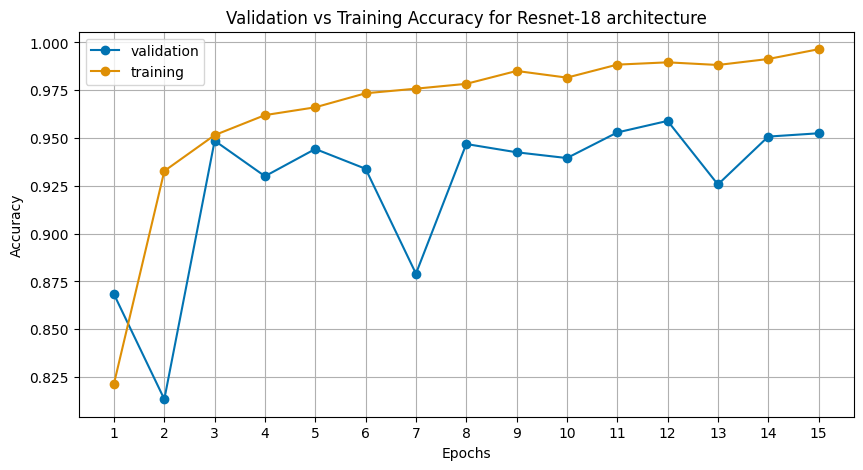

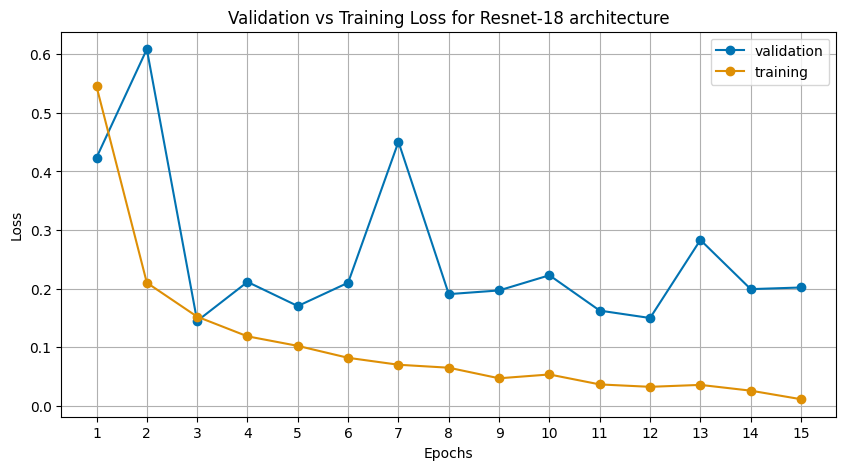

In [30]:
x_vals_resnet = list(range(1, len(architectures_resnet['valid_accuracy']) + 1))
# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_resnet, architectures_resnet['valid_accuracy'], label='validation', marker='o')
plt.plot(x_vals_resnet, architectures_resnet['train_accuracy'], label='training', marker='o')
plt.title('Validation vs Training Accuracy for Resnet-18 architecture')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals_resnet)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_resnet, architectures_resnet['valid_loss'], label='validation', marker='o')
plt.plot(x_vals_resnet, architectures_resnet['train_loss'], label='training', marker='o')
plt.title('Validation vs Training Loss for Resnet-18 architecture')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_vals_resnet)
plt.grid(True)
plt.show()

## VIT-base-16

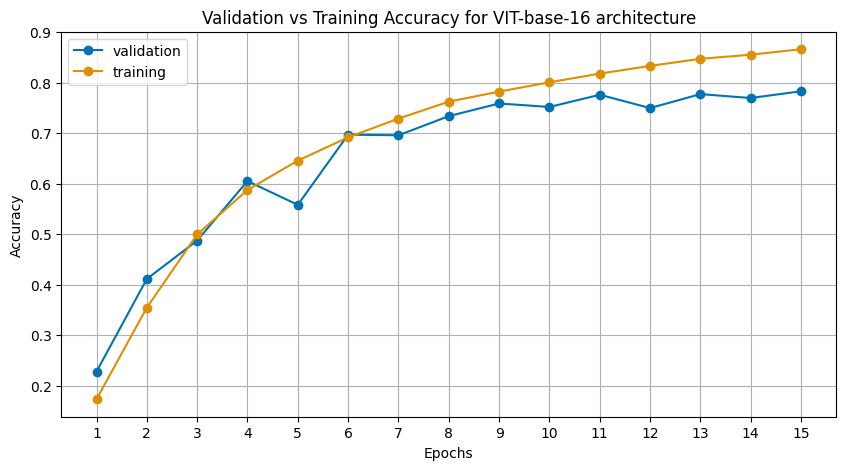

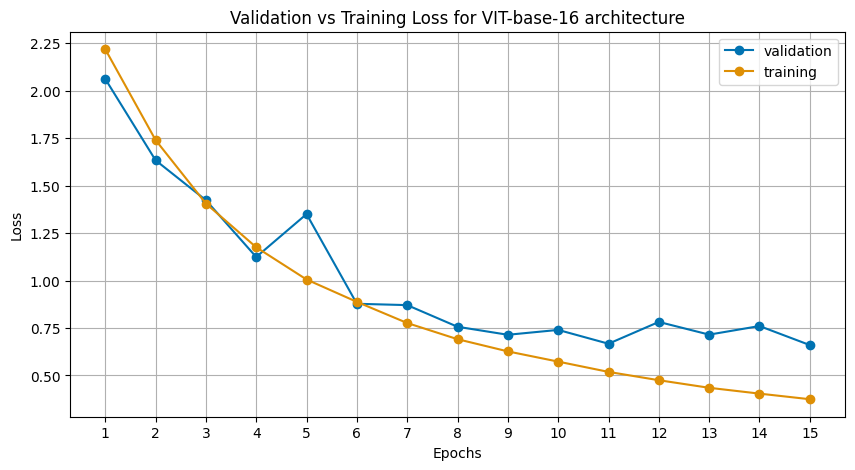

In [31]:
x_vals_vit = list(range(1, len(best_vit_base_8['valid_accuracy']) + 1))
# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_vit, best_vit_base_8['valid_accuracy'], label='validation', marker='o')
plt.plot(x_vals_vit, best_vit_base_8['train_accuracy'], label='training', marker='o')
plt.title('Validation vs Training Accuracy for VIT-base-16 architecture')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals_vit)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_vit, best_vit_base_8['valid_loss'], label='validation', marker='o')
plt.plot(x_vals_vit, best_vit_base_8['train_loss'], label='training', marker='o')
plt.title('Validation vs Training Loss for VIT-base-16 architecture')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_vals_vit)
plt.grid(True)
plt.show()

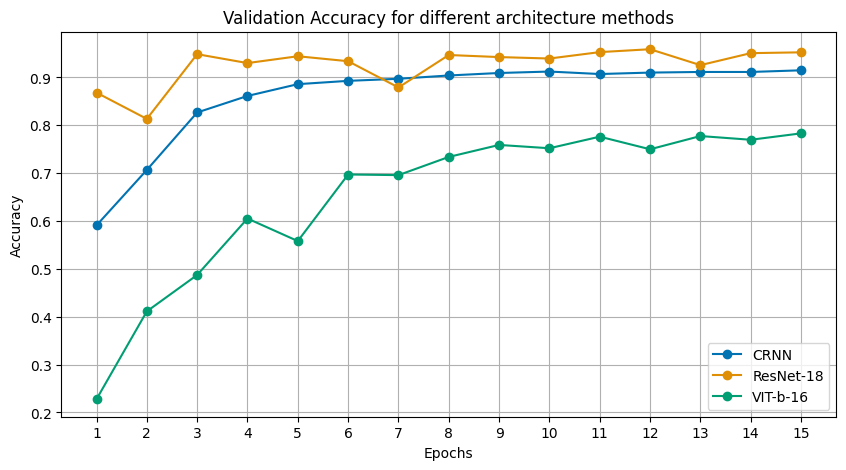

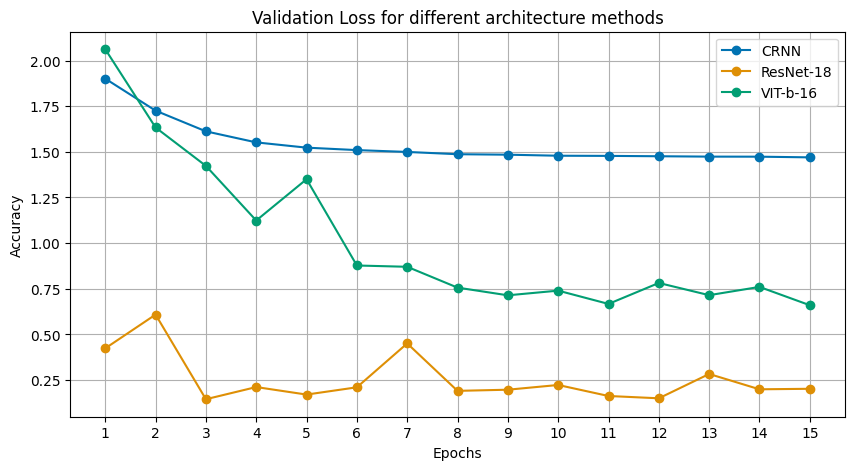

In [28]:
x_vals_crnn = list(range(1, len(architectures_crnn['valid_accuracy']) + 1))
x_vals_resnet = list(range(1, len(architectures_resnet['valid_accuracy']) + 1))
x_vals_vit = list(range(1, len(best_vit_base_8['valid_accuracy']) + 1))
# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_crnn, architectures_crnn['valid_accuracy'], label='CRNN', marker='o')
plt.plot(x_vals_resnet, architectures_resnet['valid_accuracy'], label='ResNet-18', marker='o')
plt.plot(x_vals_vit, best_vit_base_8['valid_accuracy'], label='VIT-b-16', marker='o')
plt.title('Validation Accuracy for different architecture methods')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals_resnet)
plt.grid(True)
plt.show()

sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_crnn, architectures_crnn['valid_loss'], label='CRNN', marker='o')
plt.plot(x_vals_resnet, architectures_resnet['valid_loss'], label='ResNet-18', marker='o')
plt.plot(x_vals_vit, best_vit_base_8['valid_loss'], label='VIT-b-16', marker='o')
plt.title('Validation Loss for different architecture methods')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_vals_resnet)
plt.grid(True)
plt.show()

## Result evaluation

In [15]:
model_resnet = get_resnet(9)
load_weights(model_resnet, 'saved/architectures_resnet/architectures_resnet.pth')

In [16]:
model_crnn = CustomCRNN(9)
load_weights(model_crnn, 'saved/architectures_crnn/architectures_crnn.pth')

In [17]:
vit_base = get_vit_base()
load_weights(vit_base, 'saved/best_vit_base_8/best_vit_base_8.pth')

In [18]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

def calculate_confusion_matrix(predictor: nn.Module, dataset: torch.Tensor, n_classes: int, verbose=True, batch_size=64):
    """
    Returns:
        Confusion matrix, total accuracy, accuracy per class
    """
    photos_processed = 0
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictor.eval()

    confusion_matrix = torch.zeros(n_classes, n_classes)
    true_counts_per_class = torch.zeros(n_classes)
    class_counts = torch.zeros(n_classes)

    with torch.no_grad():
        for images, true_labels in data_loader:
            images = images.to(device)
            true_labels = true_labels.to(device)
            pred = predictor(images)
            if len(pred.shape) == 2:
                pred = torch.argmax(pred, dim=1)

            for true_label, pred_label in zip(true_labels, pred):
                confusion_matrix[true_label, pred_label] += 1
                class_counts[true_label] += 1
                if true_label == pred_label:
                    true_counts_per_class[true_label] += 1

            if verbose:
                photos_processed += batch_size
                print(f'processed {photos_processed} photos')

    accuracy_per_class = (true_counts_per_class / class_counts).tolist()
    accuracy_total = float(true_counts_per_class.sum() / class_counts.sum())

    class_count = confusion_matrix.sum(axis=1)
    confusion_matrix_normalize = (confusion_matrix.T / class_count).T
    return confusion_matrix_normalize, accuracy_total, accuracy_per_class

In [19]:
def plot_confusion_matrix(matrix, class_labels, total_accuracy, small=False):
    if small:
        plt.figure(figsize=(5, 4))
    else:
        plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap='Blues', vmin=0, vmax=1)
    ticks = [i + 0.5 for i in range(len(class_labels))]
    plt.xlabel('Predicted')
    plt.xticks(ticks, labels=class_labels)
    plt.ylabel('Actual')
    plt.yticks(ticks, labels=class_labels)
    plt.title(f'Total accuracy: {total_accuracy:.3f}')
    plt.show()

### ResNet-18

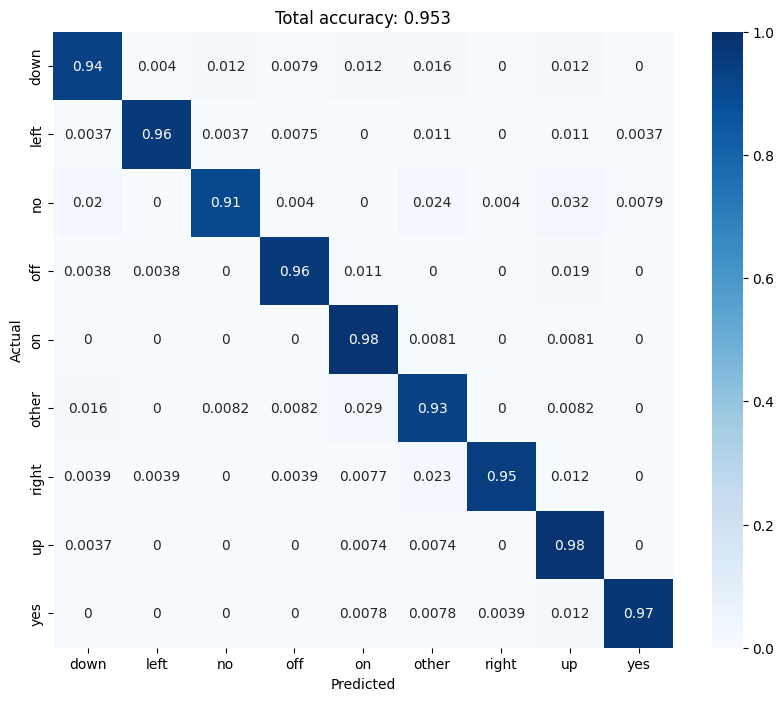

In [66]:
matrix_resnet, acc_total_resnet, acc_per_class_resnet = calculate_confusion_matrix(
    model_resnet, test_dataset_8known, n_classes=9, verbose=False,
)
plot_confusion_matrix(matrix_resnet, test_dataset_8known.classes, acc_total_resnet)

### CRNN

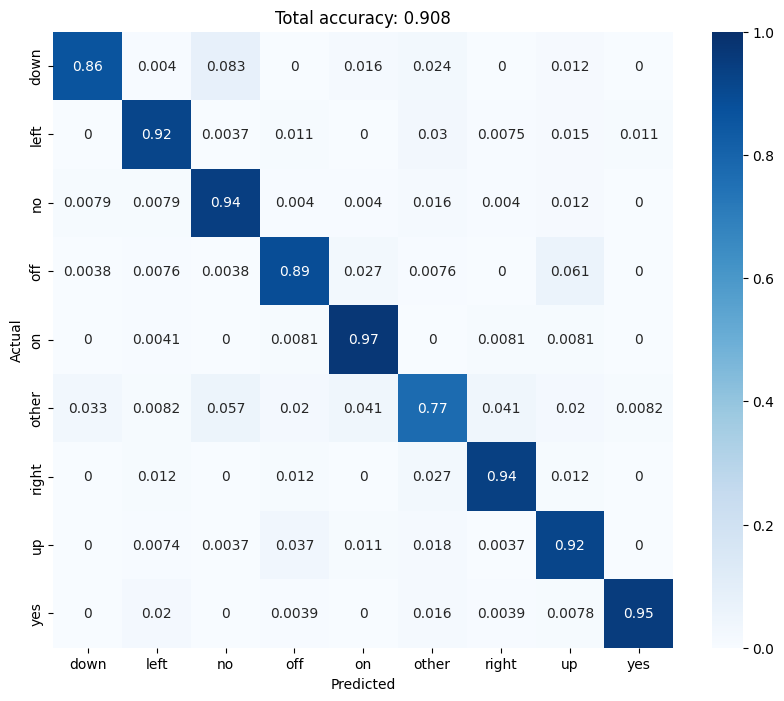

In [27]:
matrix_crnn, acc_total_crnn, acc_per_class_crnn = calculate_confusion_matrix(
    model_crnn, test_dataset_8known, n_classes=9, verbose=False,
)
plot_confusion_matrix(matrix_crnn, test_dataset_8known.classes, acc_total_crnn)

### ViT

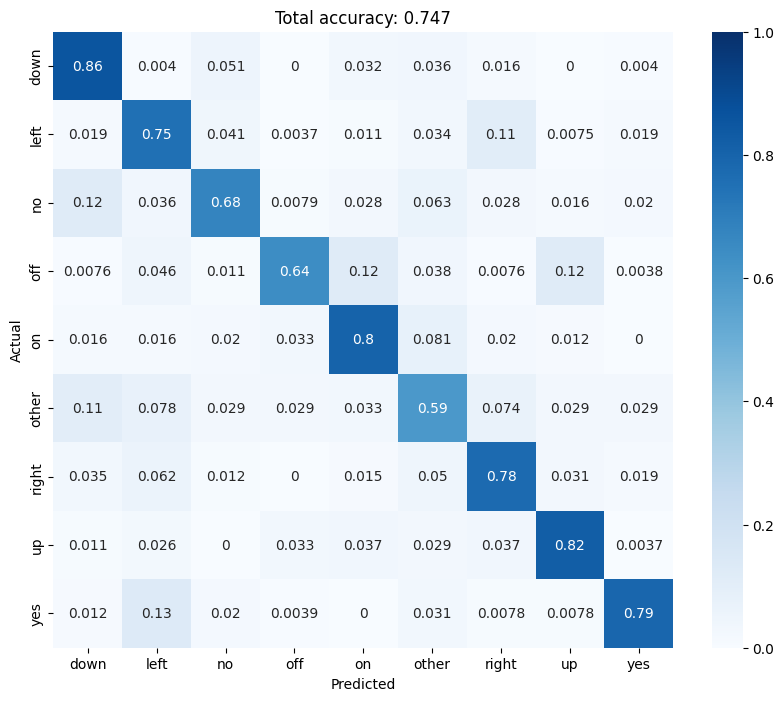

In [68]:
# 37 s
matrix_vit_base, acc_total_vit_base, acc_per_class_vit_base = calculate_confusion_matrix(
    vit_base, test_dataset_8known, n_classes=9, verbose=False,
)
plot_confusion_matrix(matrix_vit_base, test_dataset_8known.classes, acc_total_vit_base)

# Silence and Unknown detection

In [20]:
train_dataset_other = ImageFolder(f'{data_8known_base_path}/train/other', transform=simple_load)
test_dataset_other = ImageFolder(f'{data_8known_base_path}/test/other', transform=simple_load)
val_dataset_other = ImageFolder(f'{data_8known_base_path}/valid/other', transform=simple_load)

### Resnet-18

In [28]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_resnet_other = get_resnet(2)

# 25 s (2 epochs)
train(
    model_resnet_other, train_dataset_other, val_dataset_other, 
    batch_size=64, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_resnet_other.parameters(), lr=0.001), 
    max_epochs=2,
    save_name='other_resnet',
);

Epoch 1 completed! | Train loss: 0.1070 | Train accuracy: 0.9602 | Validation loss: 0.0728 | Validation accuracy: 0.9754
Epoch 2 completed! | Train loss: 0.0192 | Train accuracy: 0.9962 | Validation loss: 0.0045 | Validation accuracy: 1.0000


### Custom CRNN

In [17]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_crnn_other = CustomCRNN(2)

# 1 min (3 epochs)
train(
    model_crnn_other, train_dataset_other, val_dataset_other, 
    batch_size=32, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_crnn_other.parameters(), lr=0.0001), 
    max_epochs=3,
    save_name='other_crnn',
);

Epoch 1 completed! | Train loss: 0.3781 | Train accuracy: 0.9531 | Validation loss: 0.3316 | Validation accuracy: 0.9959
Epoch 2 completed! | Train loss: 0.3383 | Train accuracy: 0.9831 | Validation loss: 0.3232 | Validation accuracy: 1.0000
Epoch 3 completed! | Train loss: 0.3321 | Train accuracy: 0.9869 | Validation loss: 0.3204 | Validation accuracy: 0.9959


### ViT base

In [16]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

vit_base_other = get_vit_base()

# 5 min (3 epochs)
train(
    vit_base_other, train_dataset_other, val_dataset_other, 
    batch_size=16, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(vit_base_other.parameters(), lr=0.0001), 
    max_epochs=3,
    save_name='other_vit_base',
);

Epoch 1 completed! | Train loss: 1.9187 | Train accuracy: 0.7203 | Validation loss: 0.3255 | Validation accuracy: 0.9959
Epoch 2 completed! | Train loss: 0.1479 | Train accuracy: 0.9847 | Validation loss: 0.1320 | Validation accuracy: 0.9713
Epoch 3 completed! | Train loss: 0.0681 | Train accuracy: 0.9847 | Validation loss: 0.0274 | Validation accuracy: 1.0000


### Evaluation training

In [20]:
architectures_crnn_other = load_stats('./saved/other_crnn/other_crnn.json')
architectures_resnet_other = load_stats('./saved/other_resnet/other_resnet.json')
vit_base_other = load_stats('./saved/other_vit_base/other_vit_base.json')

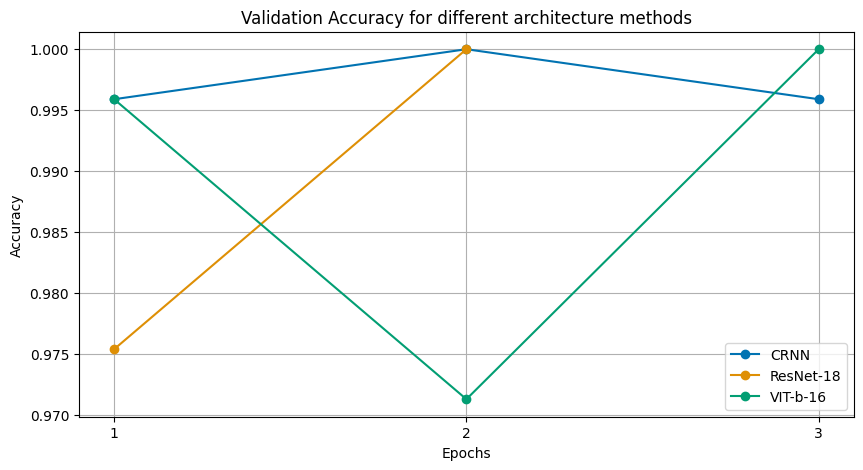

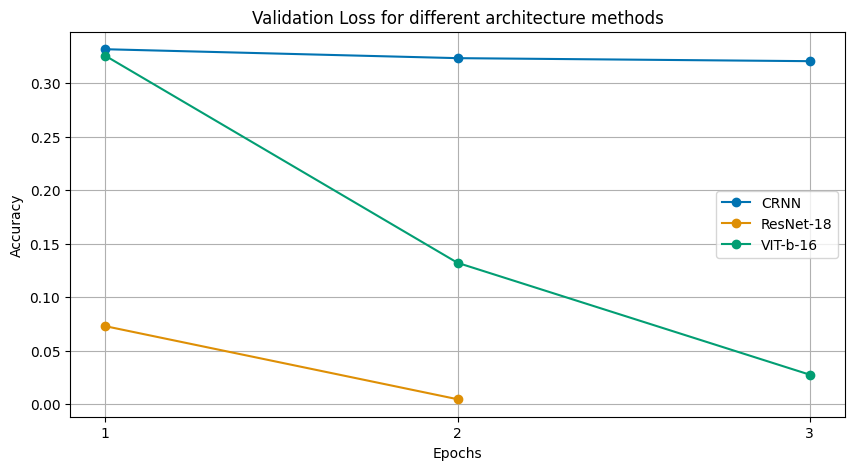

In [22]:
x_vals_crnn_other = list(range(1, len(architectures_crnn_other['valid_accuracy']) + 1))
x_vals_resnet_other = list(range(1, len(architectures_resnet_other['valid_accuracy']) + 1))
x_vals_vit_other = list(range(1, len(vit_base_other['valid_accuracy']) + 1))
# Plot accuracy
sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_crnn_other, architectures_crnn_other['valid_accuracy'], label='CRNN', marker='o')
plt.plot(x_vals_resnet_other, architectures_resnet_other['valid_accuracy'], label='ResNet-18', marker='o')
plt.plot(x_vals_vit_other, vit_base_other['valid_accuracy'], label='VIT-b-16', marker='o')
plt.title('Validation Accuracy for different architecture methods')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals_vit_other)
plt.grid(True)
plt.show()

sns.set_palette("colorblind")
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(x_vals_crnn_other, architectures_crnn_other['valid_loss'], label='CRNN', marker='o')
plt.plot(x_vals_resnet_other, architectures_resnet_other['valid_loss'], label='ResNet-18', marker='o')
plt.plot(x_vals_vit_other, vit_base_other['valid_loss'], label='VIT-b-16', marker='o')
plt.title('Validation Loss for different architecture methods')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_vals_vit_other)
plt.grid(True)
plt.show()

## Evaluation

In [21]:
model_resnet_other = get_resnet(2)
load_weights(model_resnet_other, 'saved/other_resnet/other_resnet.pth')

In [22]:
model_crnn_other = CustomCRNN(2)
load_weights(model_crnn_other, 'saved/other_crnn/other_crnn.pth')

In [23]:
vit_base_other = get_vit_base()
load_weights(vit_base_other, 'saved/other_vit_base/other_vit_base.pth')

### Resnet-18

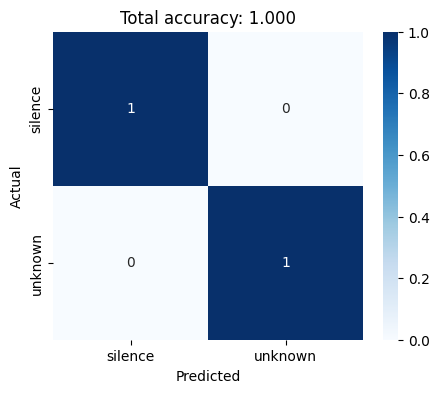

In [34]:
matrix_resnet_other, acc_total_resnet_other, acc_per_class_resnet_other = calculate_confusion_matrix(
    model_resnet_other, test_dataset_other, n_classes=2, verbose=False,
)
plot_confusion_matrix(matrix_resnet_other, test_dataset_other.classes, acc_total_resnet_other, small=True)

### Custom CRNN

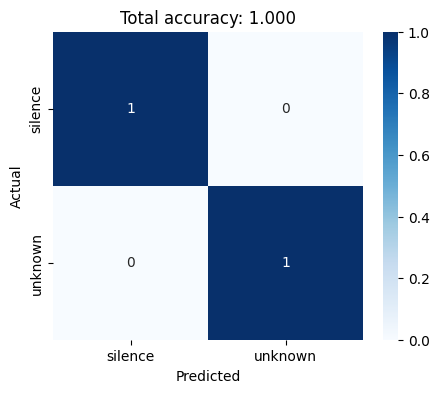

In [37]:
matrix_crnn_other, acc_total_crnn_other, acc_per_class_crnn_other = calculate_confusion_matrix(
    model_crnn_other, test_dataset_other, n_classes=2, verbose=False,
)
plot_confusion_matrix(matrix_crnn_other, test_dataset_other.classes, acc_total_crnn_other, small=True)

### ViT base

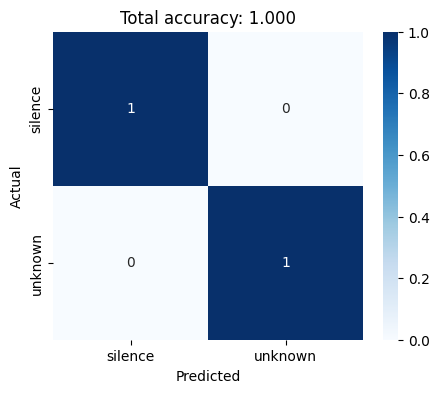

In [38]:
matrix_vit_base_other, acc_total_vit_base_other, acc_per_class_vit_base_other = calculate_confusion_matrix(
    vit_base_other, test_dataset_other, n_classes=2, verbose=False,
)
plot_confusion_matrix(matrix_vit_base_other, test_dataset_other.classes, acc_total_vit_base_other, small=True)

# Merging the two models

In [52]:
train_dataset_final = ImageFolder(f'data/final8/train', transform=simple_load)
test_dataset_final = ImageFolder(f'data/final8/test', transform=simple_load)
val_dataset_final = ImageFolder(f'data/final8/valid', transform=simple_load)

In [53]:
train_dataset_8known.class_to_idx

{'down': 0,
 'left': 1,
 'no': 2,
 'off': 3,
 'on': 4,
 'other': 5,
 'right': 6,
 'up': 7,
 'yes': 8}

In [54]:
train_dataset_other.class_to_idx

{'silence': 0, 'unknown': 1}

In [55]:
train_dataset_final.class_to_idx

{'down': 0,
 'left': 1,
 'no': 2,
 'off': 3,
 'on': 4,
 'right': 5,
 'silence': 6,
 'unknown': 7,
 'up': 8,
 'yes': 9}

In [56]:
# labels mapper for the first model
known_mapper = {}
other_idx = None

for class_name, class_label in train_dataset_8known.class_to_idx.items():
    if class_name == 'other':
        other_idx = class_label
        continue
    final_label = train_dataset_final.class_to_idx[class_name]
    known_mapper[class_label] = final_label

known_mapper

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 8, 8: 9}

In [57]:
other_idx

5

In [58]:
# labels mapper for the silence vs unknown model
other_mapper = {}

for class_name, class_label in train_dataset_other.class_to_idx.items():
    final_label = train_dataset_final.class_to_idx[class_name]
    other_mapper[class_label] = final_label

other_mapper

{0: 6, 1: 7}

In [64]:
class MergedModel:
    def __init__(self, first_predictor: nn.Module, other_predictor: nn.Module):
        self.first_predictor = first_predictor
        self.other_predictor = other_predictor

    def eval(self):
        self.first_predictor.eval()
        self.other_predictor.eval()

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        pred_proba = self.first_predictor(image)
        pred_labels = torch.argmax(pred_proba, dim=1)

        pred_other_mask = pred_labels == other_idx
        pred_known_mask = pred_labels != other_idx

        pred_labels[pred_known_mask] = pred_labels[pred_known_mask].to('cpu').apply_(known_mapper.get).to(device)

        if torch.any(pred_other_mask):
            pred_proba_other = self.other_predictor(image[pred_other_mask])
            pred_labels_other = torch.argmax(pred_proba_other, dim=1)
            # map 0, 1 to final labels
            # apply_ is only available on CPU tensors
            pred_labels_other = pred_labels_other.to('cpu').apply_(other_mapper.get).to(device)

            pred_labels[pred_other_mask] = pred_labels_other

        return pred_labels

## ResNet-18

In [65]:
merged_resnet = MergedModel(model_resnet, model_resnet_other)

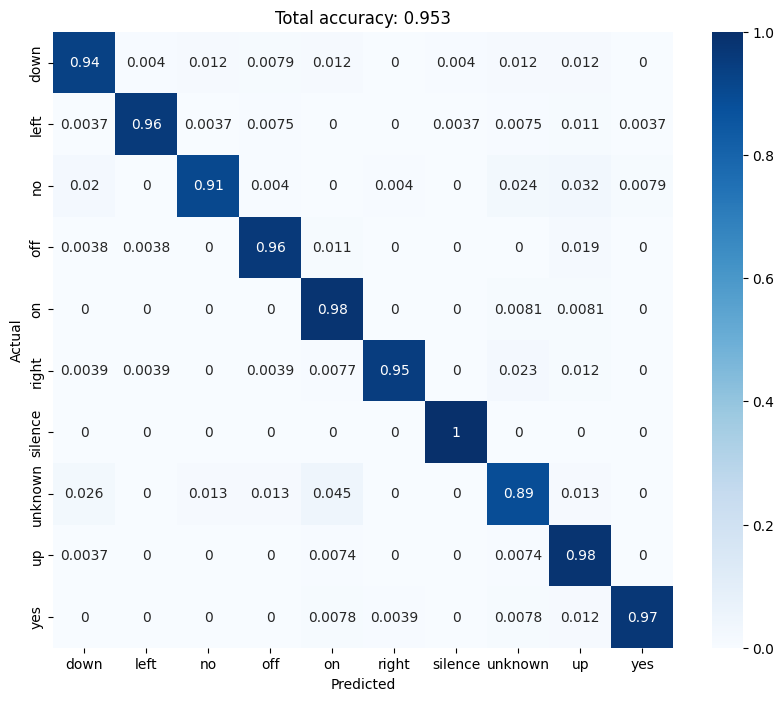

In [66]:
matrix_resnet_final, acc_total_resnet_final, acc_per_class_resnet_final = calculate_confusion_matrix(
    merged_resnet, test_dataset_final, n_classes=10, verbose=False,
)
plot_confusion_matrix(matrix_resnet_final, test_dataset_final.classes, acc_total_resnet_final)

## CRNN

In [67]:
merged_crnn = MergedModel(model_crnn, model_crnn_other)

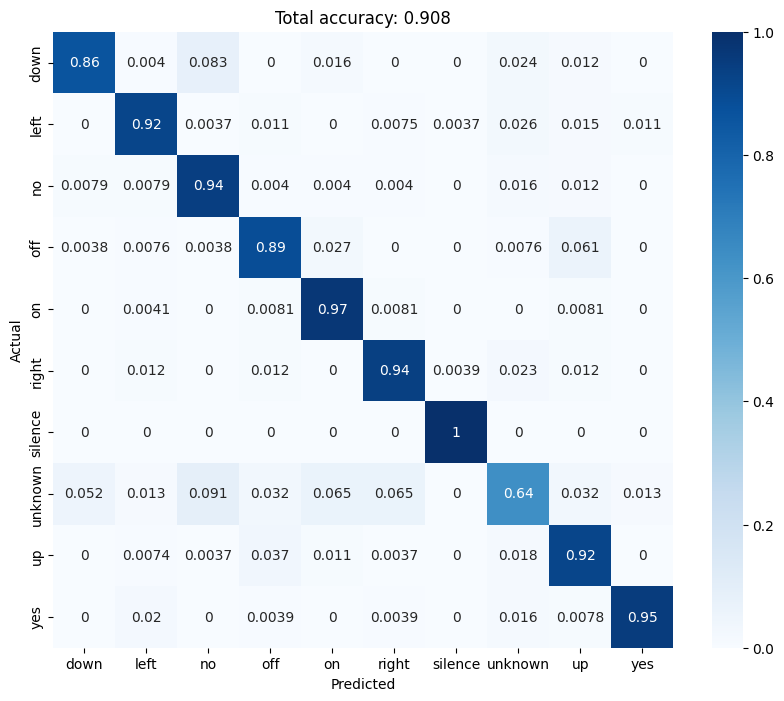

In [68]:
matrix_crnn_final, acc_total_crnn_final, acc_per_class_crnn_final = calculate_confusion_matrix(
    merged_crnn, test_dataset_final, n_classes=10, verbose=False,
)
plot_confusion_matrix(matrix_crnn_final, test_dataset_final.classes, acc_total_crnn_final)

## ViT

In [69]:
merged_vit = MergedModel(vit_base, vit_base_other)

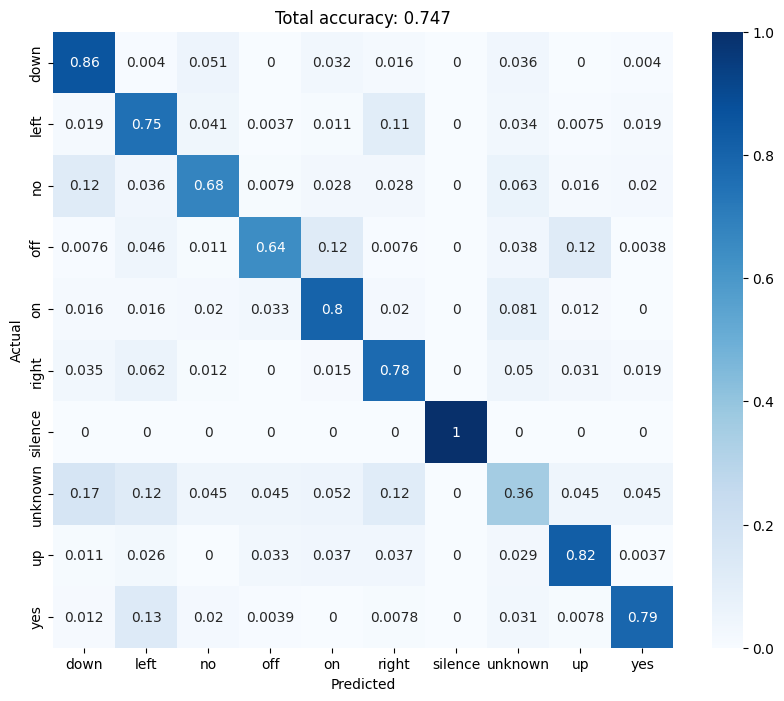

In [70]:
matrix_vit_final, acc_total_vit_final, acc_per_class_vit_final = calculate_confusion_matrix(
    merged_vit, test_dataset_final, n_classes=10, verbose=False,
)
plot_confusion_matrix(matrix_vit_final, test_dataset_final.classes, acc_total_vit_final)